In [224]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics 

import os
import pydotplus
from IPython.display import Image

In [225]:
df = pd.read_excel("/Users/snirz/presee/PreSee2022/data/PreSee.xlsx")

def objects_to_nums(df):
    df['gender'] = df['gender'].map({'Male':1, 'Female':0}).astype(int)
    df['smoking'] = df['smoking'].map({'YES':1, 'NO':0})
    df['heart_disease_hist'] = df['heart_disease_hist'].map({'YES':1, 'NO':0})
    df['heart_disease_family_hist'] = df['heart_disease_family_hist'].map({'YES':1, 'NO':0})
    df['bp_medication'] = df['bp_medication'].map({'YES':1, 'NO':0})
    df['diabetes'] = df['diabetes'].map({'YES':1, 'NO':0})
    df["work_stress_level"] = df["work_stress_level"].map({'0/5':0, '1/5':0.2, '2/5':0.4, '3/5':0.6, '4/5':0.8, '5/5':1})
    df["exercise_level"] = df["exercise_level"].map({'0/5':0, '1/5':0.2, '2/5':0.4, '3/5':0.6, '4/5':0.8, '5/5':1})
    return df
    
df = objects_to_nums(df)
df = df.dropna() # We have 23 rows of null/5 that we drop

### Preparing Data for runs 

In [226]:
df_class_names=['VeryLowScore', "LowScore", "HighScore",'VeryHighScore']
def split_to_label(df):
    
    if (df['overall_score'] <= 90):
        return 'VeryLowScore'
    elif (df['overall_score'] <= 94) and (df['overall_score'] > 90):
        return 'LowScore'
    elif (df['overall_score'] <= 95) and (df['overall_score'] > 94):
        return 'HighScore'
    else:
        return 'VeryHighScore'
df['label'] = df.apply(split_to_label, axis=1)

In [227]:
def drop_general_columns(df):
    df = df.drop(['patient_id','ecg_weight','us_weight','blood_weight','personal_weight'], axis = 1)
    return df

df = drop_general_columns(df)

In [228]:
def drop_bllod(df):
    return df.drop(['blood_test_score'], axis = 1)

def drop_ecg_test(df):
    return df.drop(['ecg_test_score'], axis = 1)

def drop_us_test(df):
    return df.drop(['us_test_score'], axis = 1)

In [229]:
def move_overall_score_to_last_column(df):
    columns = []
    for column in df.columns:
        if (column != 'overall_score'):
            columns.append(column)
    columns.append('overall_score')
    df = df[columns]
    return(df)
df = move_overall_score_to_last_column(df)

train, test = train_test_split(df, test_size=0.2)

In [214]:
def drop_tests(train, test):
    df_no_us_test = drop_us_test(df)
df_no_us_test_test= drop_us_test(df)
df_no_ecg_test = drop_ecg_test(df)
df_no_blood_test = drop_blood_test(df)

current_df = df_no_blood_test

In [215]:
def get_predictors_names(dataframe):
    names = list(dataframe.columns)
    predictors_names=names[:-2]
    return predictors_names
df_predictors_names = get_predictors_names(current_df)

#### 8. Which features are categorized as the label (target) ? (Provide a verbal answer)

The feature categorized as the label is "Acceptable," as this is the feature we are trying to predict. i.e., Are the cars acceptable for potential buyers?

# PART 2: BUILDING A DECISION TREE MODEL
## TASK 4: BUILDING THE MODEL
### Building Decisition Tree

(1) Saving data in array

In [216]:
def get_nd(dataframe):
    nd = dataframe.values
    return nd
nd = get_nd(current_df)

(2) Split array into train and test

In [217]:
train, test = train_test_split(current_df, test_size=0.2)

def get_nd(dataframe):
    nd = dataframe.values
    return nd
nd_test = get_nd(test)
nd_train = get_nd(train)

(3) predictors label separations X include the predictors columns Y is the label column

In [218]:
def get_XY(ndarray):
    X=ndarray[:,:-2]
    Y= ndarray[:,-2]
    return X,Y
X_train,Y_train = get_XY(nd_train)
X_test,Y_test = get_XY(nd_test)

(4) Build model with training data

In [219]:
def get_clf(X,Y):
    clf= DecisionTreeClassifier(criterion="entropy",  min_impurity_decrease=0.01)
    clf.fit(X, Y)
    return(clf)
clf=get_clf(X_train,Y_train)

(5) Make predictions for testing data

In [220]:
def get_pred(classifier, X):
    y_pred = classifier.predict(X)
    return(y_pred)
y_pred = get_pred(clf, X_test)

(6) calculate Accuracy, frequency of cases when the classifier is correct

In [221]:
def get_accuracy(test,pred): 
    accuracy = metrics.accuracy_score(test, pred)
    return accuracy
clf_accuracy=get_accuracy(Y_test,y_pred) 
print(clf_accuracy)

0.5335820895522388


(7) Generate a graph

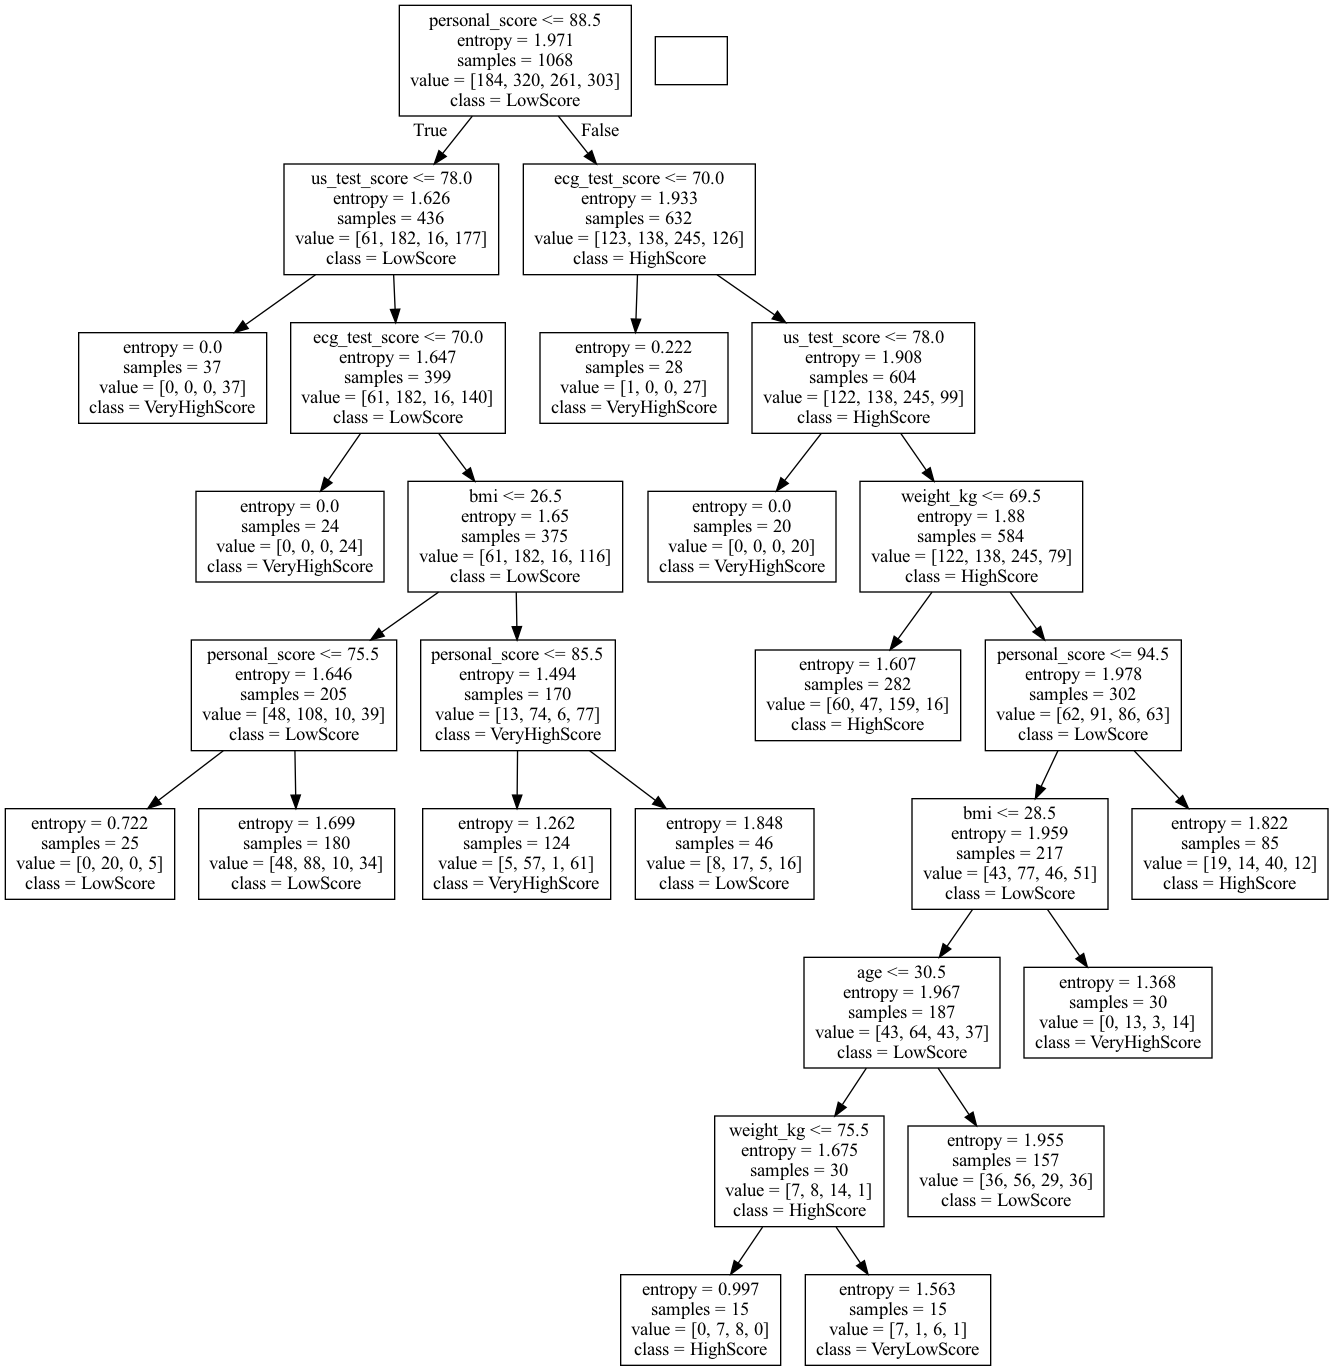

In [222]:
def get_graph(clf,df_predictors_names):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=df_predictors_names,  
                                class_names=df_class_names)
    graph = pydotplus.graph_from_dot_data(dot_data) 
    return graph
graph = get_graph(clf,df_predictors_names)

def get_image(graph):
    image=Image(graph.create_png())
    return image
image = get_image(graph)
image

#### 10. As can be seen from the decision tree, the attribute that was selected for the root of the tree is ‘Safety’. The Gini index value of this attribute is 0.416. Provide a detailed calculation of this value (Hint: You can use Excel to perform the calculation). In addition, the Gini index value of the first tree node is 0.416, explain what this value represents.

In [175]:
def calc_root_gini(train_set):
    all_samples = train_set.shape[0] ## All Samples
    acceptables = train_set[train_set[:,-2] == 1].shape[0] ## Acceptable Samples from all samples
    unacceptables = train_set[train_set[:,-2] == 0].shape[0] ## Unacceptable Samples from all samples
    prop_1 = (acceptables/all_samples) ** 2 
    prop_2 = (unacceptables/all_samples) ** 2
    return (1 - (prop_1 + prop_2))

print("Root gini is: " + str(calc_root_gini(nd_train)) + " and it represents the gini index of the whole decision tree")

Root gini is: 1.0 and it represents the gini index of the whole decision tree


In [14]:
# Gini index of the Safety feature

def caculate_gini(train_set, column_index):
    feature = train_set[:, column_index]
    all_samples = train_set.shape[0]
    sum = 0
    
    for v in np.unique(feature):
        current_data = train_set[train_set[:, column_index] == v]
        current_group_size = current_data.shape[0]
        num_acceptable = current_data[current_data[:, -2] == 1].shape[0]
        num_unacceptable = current_data[current_data[:, -2] == 0].shape[0]
        sum += (1 - ((num_acceptable / current_group_size) ** 2 + (num_unacceptable / current_group_size) ** 2)) * (current_group_size / all_samples)
    return sum
    
    
    
print("Safety gini is: " + str(caculate_gini(nd_train, 5)))


Safety gini is: 0.31859082506353753


#### 11. Below are three used cars offered for sale. Based on the decision tree, determine for each of them whether it will be acceptable or not (Provide a verbal answer):
* Car with a low buying price, very high maintenance price, 3 doors, 2 persons can be carried, medium luggage boot and low in safety.
* Car with a high or very high buying price, medium maintenance price, 4 doors, 4 or more persons can be carried, big luggage boot and medium or high in safety.
* Car with a medium buying, low maintenance price, 2 doors, 2 persons can be carried, small luggage boot and medium or high in safety.

## TASK 5: EVALUATE THE MODEL
#### 12. Use the Accuracy measure to evaluate the mode you have created in Task 4.

In [16]:
print(clf_accuracy) # Calculated before

0.92


#### 13. (Use your own words) Describe, in the context of the model you have built, the meaning of the numerical result you have received for the Accuracy measure (Provide a verbal answer using terms such as classification matrix, True Positive, etc.)

The Confusion Matrix visually represents the difference between actual and predicted data. The matrix measures the performance of the classification model.

* True positive: The ML model predicts a positive value in reality as a positive in the model.
* False-positive: The ML model predicts a false value in reality as positive in the model.
* True Negative: The ML Model predicts a false value in reality as false in the model.
* False Negative: The ML Model predicts a true value in reality as false in the model. 

We have a total test sample of 550. For each instance, we calculate whether it was a false positive or false negative, sum the results, and then divide by 550; therefore, we get a 0.92 accuracy measure. 
I.e. [(false positive) + (false negative)]/(test sample)] = 0.92

In [17]:
# Confusion Matrix:
from sklearn.metrics import confusion_matrix 
print("Confusion matrix ")
confusion_matrix(Y_test,y_pred)

Confusion matrix 


array([[350,  30],
       [ 14, 156]])

As we can see (350+30+14+156) = 550 where false answers are (30+14) = 44. SO we get 44/550 = 0.08, so therefore our accuracy is 1-0.08 = 0.92

#### 14. (Use your own words) Describe one prominent disadvantage of the Accuracy measure you have calculated.

The prominent disadvantage that the accuracy measure we have calculated is that it just sums all wrong outputs and divides it by total number of samples. But if the data is unbalanced, i.e. most of the cars acceptable or unacceptable, then the algorithm might seems to have high degree of accuracy, but in reality it is because of unbalanced data.